In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving prices.csv to prices (1).csv
User uploaded file "prices.csv" with length 51667341 bytes


In [ ]:
ls

prices.csv  sample_data/


Real-life Problem:
Stock Price is difficult to predict since it will be influenced by many factors. It can be impacted by
government policy, phycological factors, etc. The common trend towards the stock market
among the society is highly risky for investment so most of the people are not able to make
decisions based on common trends.

Aim:
To work historical data of the stock prices of public listed companies and implemented a
machine learning model based on Long Short Term Memory(LSTM) in order to predict the
future price. 

Dataset details:
2 sets of data.
prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies
new on stock market date range is shorter. There have been approx. 140 stock splits in that time,
this set doesn't account for that.
prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
The dataset is a time series data, including the opening price of the stock in market , the lowest
price the stock in the market, date of the stock filling, closing price of the stock , the number of
shares traded during the day.

Source of dataset : https://www.kaggle.com/dgawlik/nyse

Algorithm considered:

Will implement the prediction model with XGBoost or/and LSTM. If time is allowed, would like to
implement the model with both algorithms to compare which algorithms performs better. 

# EDA

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import sqrt

In [ ]:
# Retrieve data
prices = pd.read_csv('prices.csv')
#prices_split_adjusted = pd.read_csv('prices-split-adjusted.csv')

In [ ]:
prices.sample(5)

,date,symbol,open,close,low,high,volume
663219,2015-07-07,AON,99.699997,100.180000,98.330002,100.230003,723800.0
624373,2015-03-13,HSY,100.550003,99.879997,99.099998,100.760002,783500.0
411642,2013-06-21,HBI,51.570000,49.740002,48.950001,51.680000,7334000.0
76375,2010-08-25,INTU,42.250000,42.599998,41.980000,42.650002,5864200.0
499380,2014-03-10,RF,11.000000,10.900000,10.830000,11.060000,14406100.0


In [ ]:
prices_split_adjusted.sample(5)

,date,symbol,open,close,low,high,volume
715772,2015-12-03,PLD,42.290001,41.480000,41.290001,42.730000,4270600.0
755753,2016-03-31,SYY,46.619999,46.730000,46.520000,46.900002,3243900.0
178879,2011-07-07,PCG,42.799999,42.529999,42.299999,42.939999,1702600.0
448529,2013-10-08,VRSN,50.590000,49.680000,49.439999,50.869999,1132100.0
835359,2016-11-15,CMG,412.989990,400.000000,397.920013,413.200012,1201500.0


In [ ]:
prices.isna().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [ ]:
prices_split_adjusted.isna().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [ ]:
prices_split_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [ ]:
prices['symbol'].unique()

In [ ]:
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [ ]:
len(prices['symbol'].unique())

501

In [ ]:
#AAPL FB GOOG F TSLA
#df = df_prices.loc[(df_prices['symbol'] == 'GOOG')|(df_prices['symbol'] == 'FB')|(df_prices['symbol'] == 'F')|(df_prices['symbol'] == 'TSLA')]

def selectCode(stockCode):
  df = prices.loc[(prices['symbol'] == stockCode)]
  df['date'] = pd.to_datetime(df['date'])
  df = df.sort_index(ascending=True, axis=0)
  df = df.set_index('date')
  df = df[['close']]
  return df, stockCode

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


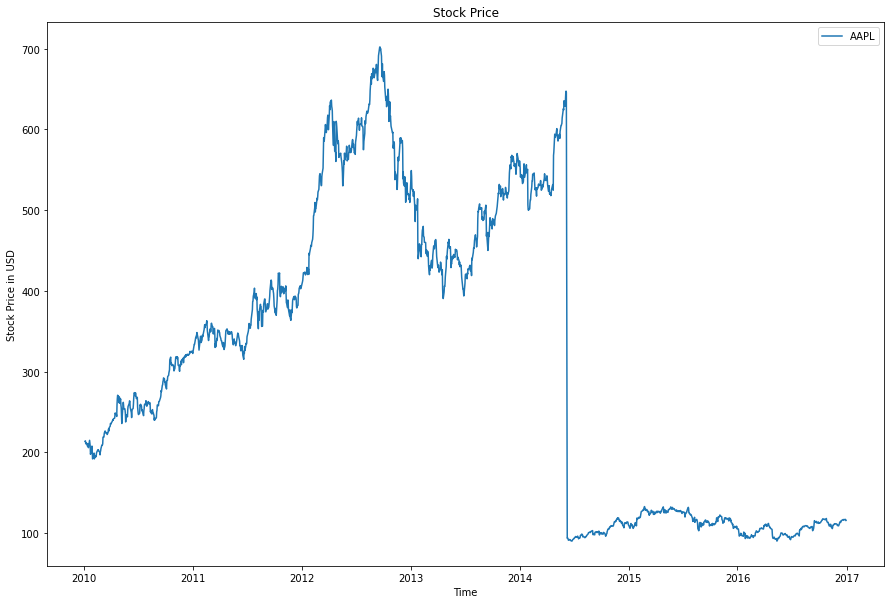

In [ ]:
plt.figure(figsize = (15,10))
#for i in ('AAPL', 'FB' ,'GOOG', 'F', 'TSLA'):
for i in ('AAPL',''):
  df, scode = selectCode(i)
  plt.plot(df, label=scode)
  plt.title('Stock Price')
  plt.xlabel('Time')
  plt.ylabel('Stock Price in USD')
plt.legend(loc='best')
plt.show()

In [ ]:
# take long time
def normalize(train):
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm

# Feature Engineering & Visualization



In [ ]:
stockCode = 'AAPL'
df = prices.loc[(prices['symbol'] == stockCode)]
df['date'] = pd.to_datetime(df['date'])
df = df.sort_index(ascending=True, axis=0)
df = df.set_index('date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.describe()

,open,close,low,high,volume,SMA_5,SMA_15,SMA_ratio,SMA5_Volume,SMA15_Volume,SMA_Volume_Ratio,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,Diff,Up,Down,avg_5up,avg_5down,avg_15up,avg_15down,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio,5Ewm,15Ewm,MACD,15MA,SD,upperband,lowerband,RC
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03,1762.000000,1762.000000,1762.000000,1.762000e+03,1.762000e+03,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1762.000000,1762.000000,1762.000000,1762.000000,1761.000000,1761.000000,1761.000000,1747.000000
mean,313.076311,312.927066,309.828241,315.911288,9.422578e+07,313.037520,313.308317,1.010512,9.434887e+07,9.465091e+07,0.996591,303.559432,321.656277,294.437220,330.353320,55.584053,58.423235,55.615961,55.559581,1.005682,-0.055758,2.047666,2.103424,2.047891,2.103863,2.048690,2.106995,inf,inf,54.332443,54.357139,1.139231,313.037839,313.318198,0.280360,313.308317,9.845009,333.054723,293.674685,0.006021
std,185.299468,185.147104,183.383917,186.898177,6.020519e+07,184.597720,183.431334,0.189032,5.278866e+07,4.846297e+07,0.193463,179.718180,190.051343,174.286057,194.328758,31.507895,31.163821,23.528270,15.175825,0.370152,14.579034,4.044603,13.695631,2.092077,6.207969,1.499795,3.683178,NaN,NaN,28.677697,18.028795,3.468414,184.373788,182.783442,15.817679,183.431334,21.433575,198.798444,177.413349,0.101163
min,90.000000,90.279999,89.470001,90.699997,1.147590e+07,90.656002,91.805334,0.932222,1.891554e+07,2.506430e+07,0.558141,89.470001,92.000000,89.470001,94.099998,0.000000,0.000000,2.172266,16.843951,0.039400,-551.870026,0.000000,0.000000,0.000000,0.000000,0.116667,0.000000,0.000000,0.003920,0.000000,0.390493,0.000000,91.677701,94.754340,-27.471810,91.805334,0.261626,93.869557,-265.529694,-0.859868
25%,115.222498,115.190002,114.002500,116.362499,4.917478e+07,115.224499,115.013834,0.979580,5.120507e+07,5.212147e+07,0.863665,111.800003,117.660002,108.427502,119.750000,27.247047,30.462006,36.505817,45.133164,0.731970,-1.939991,0.000000,0.000000,0.555998,0.396001,0.704666,0.588667,0.471644,0.723577,32.048773,41.981129,0.670419,115.408013,115.198371,-3.708566,115.013834,2.581518,120.634375,108.980198,-0.027756
50%,318.230007,318.240007,316.545002,320.600008,8.050385e+07,318.531002,318.336334,0.995429,8.401372e+07,8.759352e+07,0.973324,310.685001,323.990005,300.870010,325.720005,59.074463,64.509932,55.871593,55.587830,1.003581,0.119995,0.119995,0.000000,1.300003,1.009999,1.792000,1.267999,1.239670,1.139716,55.350574,53.264832,1.001230,318.252901,317.362237,-0.657842,318.336334,6.196086,325.583402,300.277028,0.011630
75%,470.880016,472.592512,467.972513,478.110008,1.210816e+08,472.299001,476.353167,1.013004,1.254223e+08,1.283927e+08,1.111858,453.980003,493.542484,441.999996,510.039992,86.068114,87.052255,75.521388,66.956204,1.257475,2.380005,2.380005,1.939991,2.920003,2.511999,3.086664,2.468665,3.591151,2.092895,78.218969,67.667832,1.327371,471.925309,476.366318,2.006141,476.353167,12.020174,511.056781,437.947610,0.056207
max,702.409988,702.100021,699.569977,705.070023,4.702495e+08,700.516007,684.177340,4.871617,3.537416e+08,2.428657e+08,1.796628,693.619987,705.070023,656.000008,705.070023,100.000000,100.000000,96.761849,90.897817,2.298374,49.720017,49.720017,551.870026,13.974002,111.121997,6.723999,37.672665,inf,inf,100.000000,100.000000,124.977849,697.483854,685.461543,203.887326,684.177340,282.081329,981.218162,657.098873,0.211817


In [ ]:
# Simple Moving Average (SMA)
df['SMA_5'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window = 5,min_periods=1).mean())
df['SMA_15'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window = 15,min_periods=1).mean())
df['SMA_ratio'] = df['SMA_15'] / df['SMA_5']

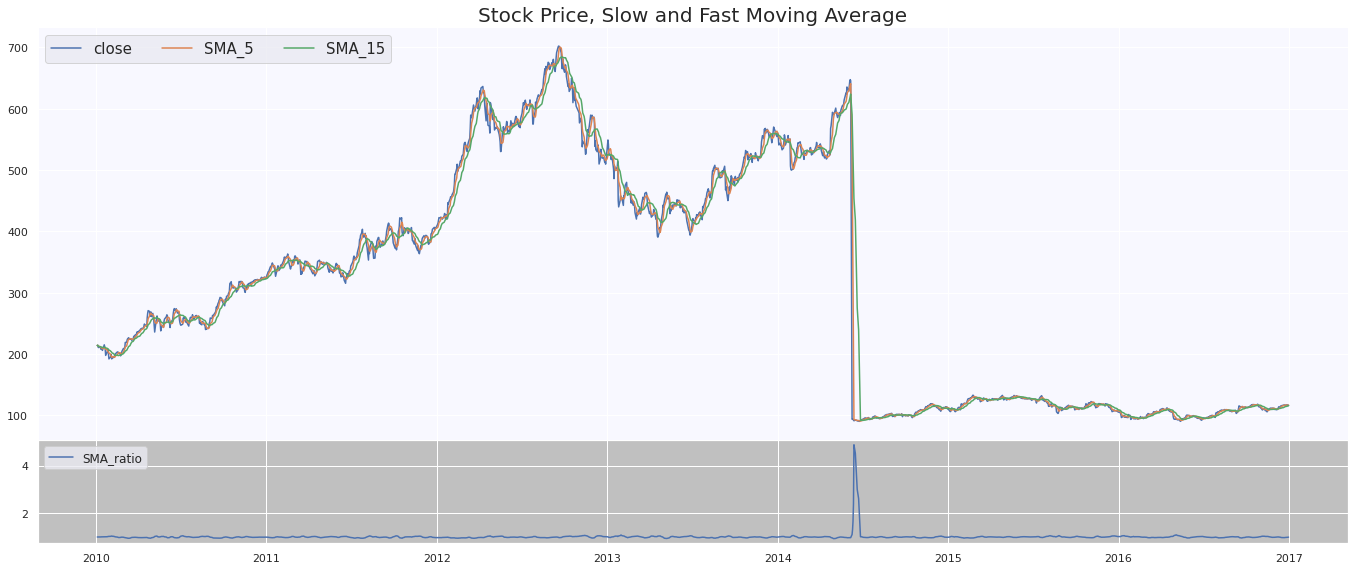

In [ ]:
#Plotting
def plotting(df, columns, cols, title):
  sns.set()
  fig = plt.figure(facecolor = 'white', figsize = (20,10))
  ax0 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
  ax0.plot(df.loc[:,columns])
  ax0.set_facecolor('ghostwhite')
  ax0.legend(columns,ncol=3, loc = 'upper left', fontsize = 15)
  plt.title('Stock Price, ' +title, fontsize = 20)

  ax1 = plt.subplot2grid((6,4), (5,0), rowspan=1, colspan=4, sharex = ax0)
  ax1.plot(df.loc[:,cols])
  ax1.legend(cols,ncol=3, loc = 'upper left', fontsize = 12)
  ax1.set_facecolor('silver')
  plt.subplots_adjust(left=.09, bottom=.09, right=1, top=.95, wspace=.20, hspace=0)
  plt.show()

SMA = ['close','SMA_5','SMA_15']
SMAR = ['SMA_ratio']
plotting(df,SMA,SMAR, 'Slow and Fast Moving Average')

In [ ]:
# Simple Moving Average Volume
df['SMA5_Volume'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window = 5,min_periods=1).mean())
df['SMA15_Volume'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window = 15,min_periods=1).mean())
df['SMA_Volume_Ratio'] = df['SMA5_Volume']/df['SMA15_Volume']

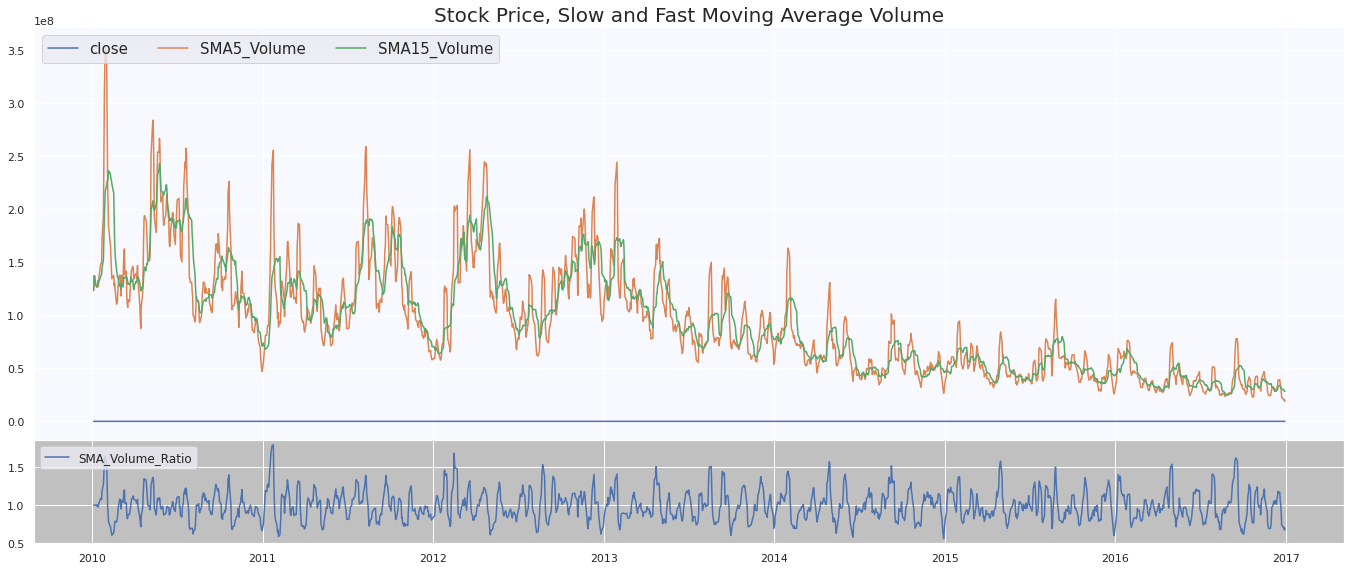

In [ ]:
SMAV = ['close','SMA5_Volume','SMA15_Volume']
SMAVR = ['SMA_Volume_Ratio']
plotting(df,SMAV,SMAVR, 'Slow and Fast Moving Average Volume')

In [ ]:
# Stochastic Oscillators

df['Lowest_5D'] = df['low'].transform(lambda x: x.rolling(window = 5, min_periods=1).min())
df['High_5D'] = df['high'].transform(lambda x: x.rolling(window = 5, min_periods=1).max())
df['Lowest_15D'] = df['low'].transform(lambda x: x.rolling(window = 15, min_periods=1).min())
df['High_15D'] = df['high'].transform(lambda x: x.rolling(window = 15, min_periods=1).max())

df['Stochastic_5'] = ((df['close'] - df['Lowest_5D'])/(df['High_5D'] - df['Lowest_5D']))*100
df['Stochastic_15'] = ((df['close'] - df['Lowest_15D'])/(df['High_15D'] - df['Lowest_15D']))*100

df['Stochastic_%D_5'] = df['Stochastic_5'].rolling(window = 5, min_periods=1).mean()
df['Stochastic_%D_15'] = df['Stochastic_5'].rolling(window = 15, min_periods=1).mean()

df['Stochastic_Ratio'] = df['Stochastic_%D_5']/df['Stochastic_%D_15']

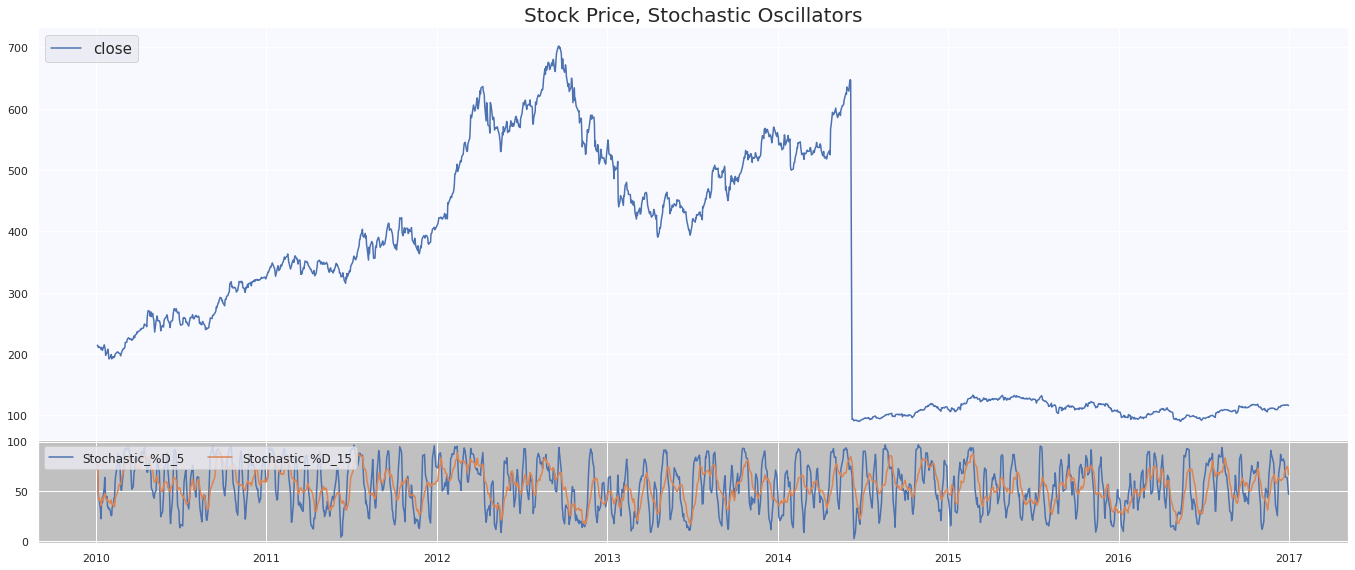

In [ ]:
Close = ['close']
SOR = ['Stochastic_%D_5', 'Stochastic_%D_15']
plotting(df, Close, SOR, 'Stochastic Oscillators')

In [ ]:
# Relative Strength Index (RSI)

df['Diff'] = df['close'].transform(lambda x: x.diff())
df['Up'] = df['Diff']
df.loc[(df['Up']<0), ['Up']] = 0

df['Down'] = df['Diff']
df.loc[(df['Down']>0), ['Down']] = 0 
df['Down'] = abs(df['Down'])

df['avg_5up'] = df['Up'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['avg_5down'] = df['Down'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

df['avg_15up'] = df['Up'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
df['avg_15down'] = df['Down'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())

df['RS_5'] = df['avg_5up'] / df['avg_5down']
df['RS_15'] = df['avg_15up'] / df['avg_15down']

df['RSI_5'] = 100 - (100/(1+df['RS_5']))
df['RSI_15'] = 100 - (100/(1+df['RS_15']))

df['RSI_ratio'] = df['RSI_5']/df['RSI_15']

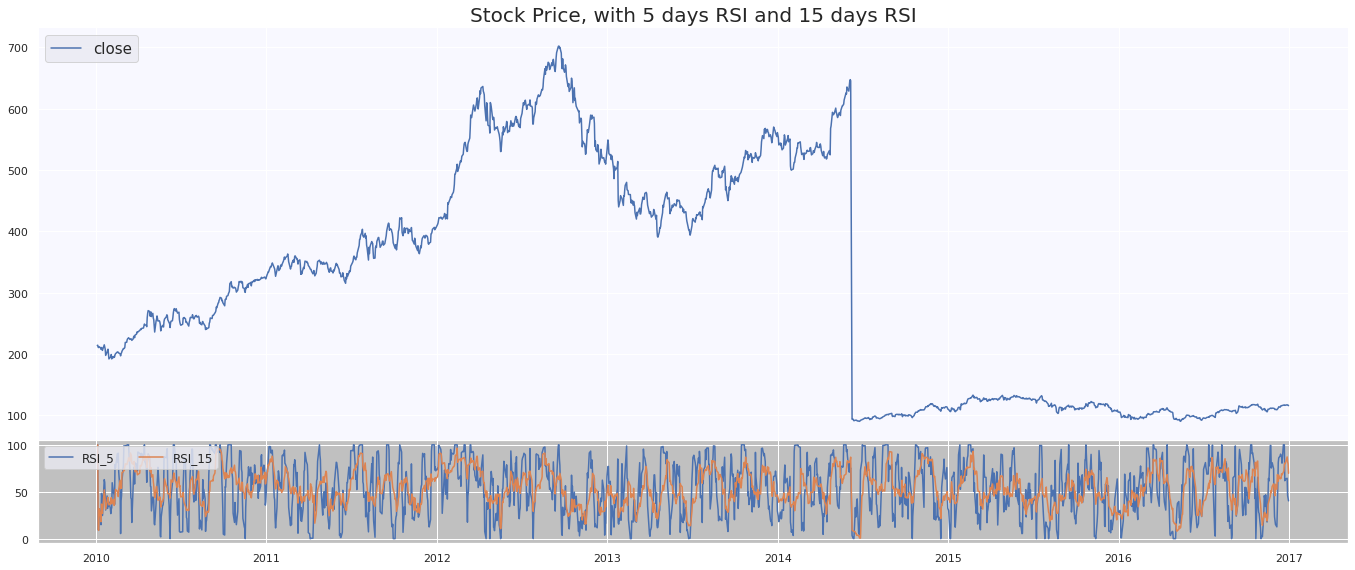

In [ ]:
Close = ['close']
RSIR = ['RSI_5', 'RSI_15']
plotting(df, Close, RSIR, 'with 5 days RSI and 15 days RSI')

In [ ]:
# Moving Average Convergence Divergence

df['5Ewm'] = df['close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
df['15Ewm'] = df['close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
df['MACD'] = df['15Ewm'] - df['5Ewm']

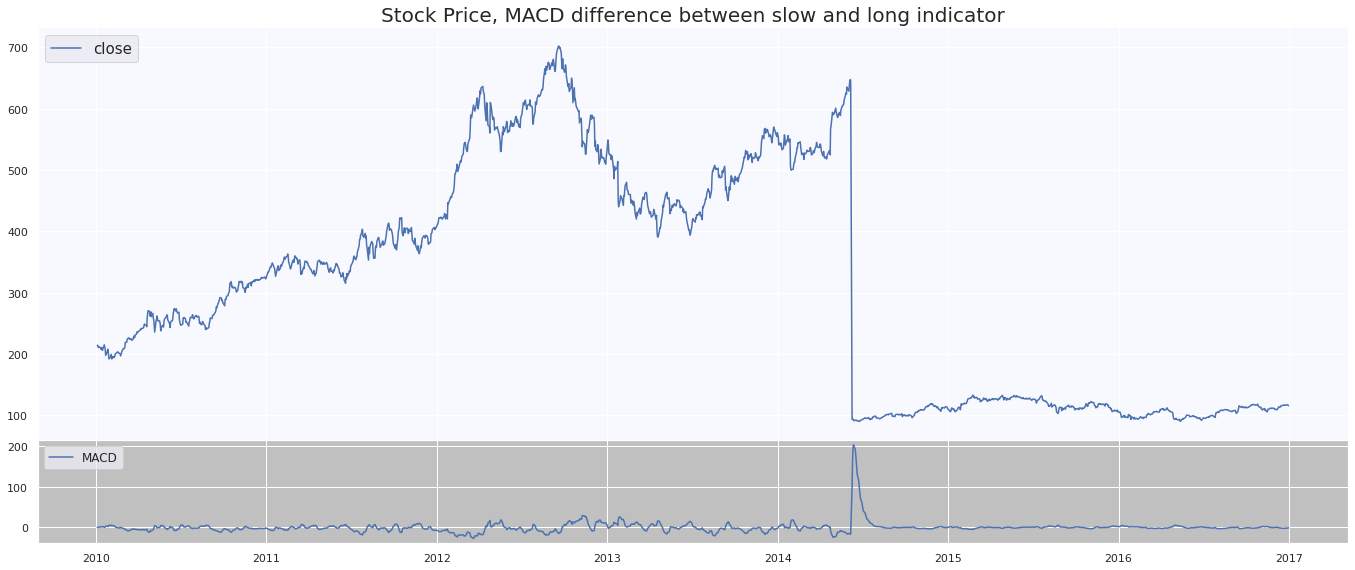

In [ ]:
MACD = ['MACD']
plotting(df, Close, MACD, 'MACD difference between slow and long indicator')

In [ ]:
# Bollinger Bands
df['15MA'] = df['close'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
df['SD'] = df['close'].transform(lambda x: x.rolling(window=15, min_periods=1).std())
df['upperband'] = df['15MA'] + 2*df['SD']
df['lowerband'] = df['15MA'] - 2*df['SD']

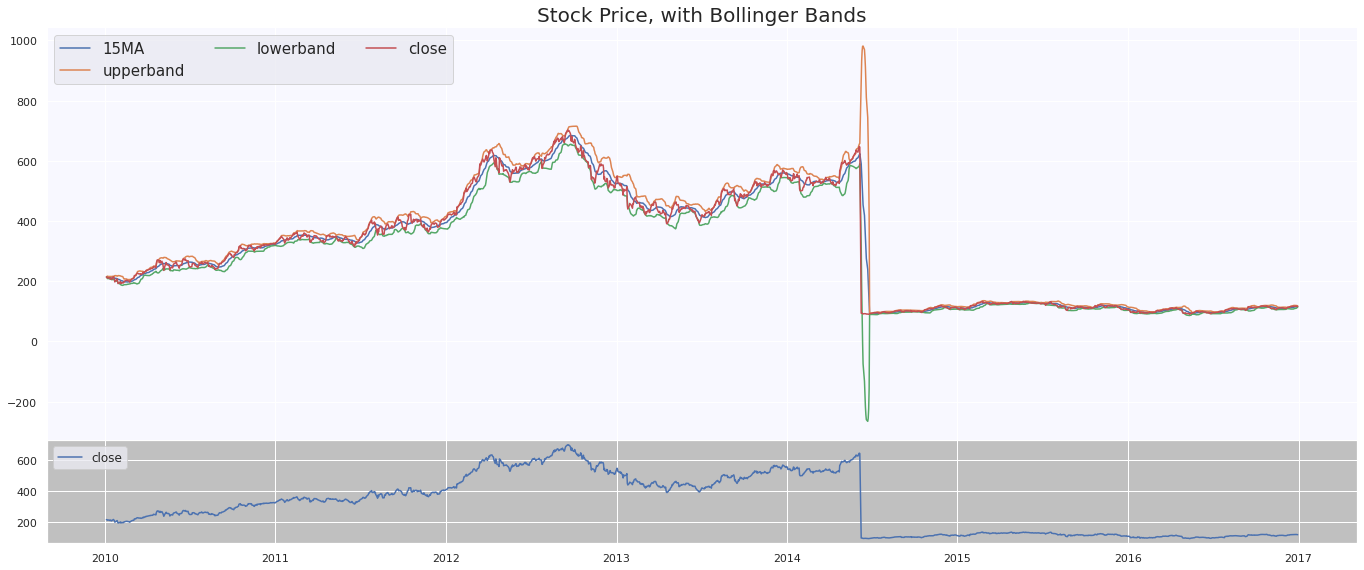

In [ ]:
BB = ['15MA', 'upperband', 'lowerband', 'close']
plotting(df, BB, Close, 'with Bollinger Bands')

In [ ]:
# Rate of Change
df['RC'] = df['close'].transform(lambda x: x.pct_change(periods = 15)) 

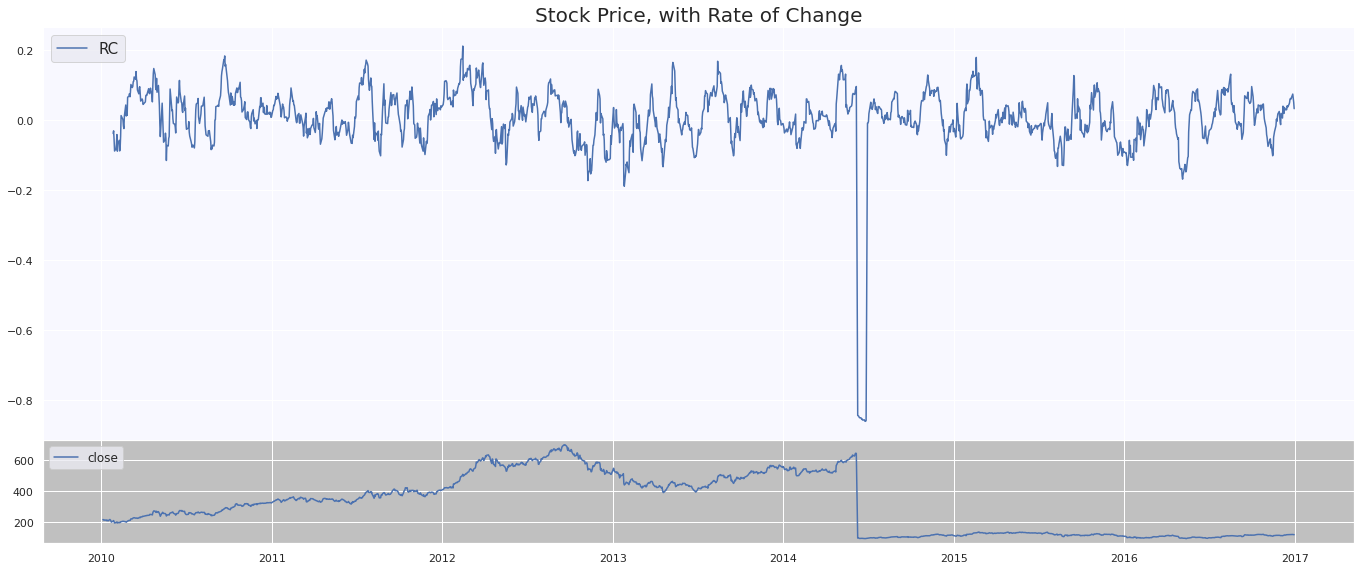

In [ ]:
RC = ['RC']
plotting(df, RC, Close, 'with Rate of Change')

# Model Implementation

In [ ]:
print(df.shape)
df.columns

(1762, 41)


Index(['symbol', 'open', 'close', 'low', 'high', 'volume', 'SMA_5', 'SMA_15',
       'SMA_ratio', 'SMA5_Volume', 'SMA15_Volume', 'SMA_Volume_Ratio',
       'Lowest_5D', 'High_5D', 'Lowest_15D', 'High_15D', 'Stochastic_5',
       'Stochastic_15', 'Stochastic_%D_5', 'Stochastic_%D_15',
       'Stochastic_Ratio', 'Diff', 'Up', 'Down', 'avg_5up', 'avg_5down',
       'avg_15up', 'avg_15down', 'RS_5', 'RS_15', 'RSI_5', 'RSI_15',
       'RSI_ratio', '5Ewm', '15Ewm', 'MACD', '15MA', 'SD', 'upperband',
       'lowerband', 'RC'],
      dtype='object')

In [ ]:
def denormalization(train):
  denorm = train.apply(lambda x: x*(np.max(data['close'])-np.min(data['close']))+np.mean(data['close']))
  return denorm

def Trainer(train, pastDay, futureDay):

  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]['close']))
  return np.array(X_train), np.array(Y_train)

def splitData(X,y,rate):
  X_train = X[int(X.shape[0]*rate):]
  y_train = y[int(y.shape[0]*rate):]
  X_test = X[:int(X.shape[0]*rate)]
  y_test = y[:int(y.shape[0]*rate)]
  return X_train, X_test, y_train, y_test

def TrainTestLossPlotting(history, pastDay, futureDay): 
  plt.title('TrainTestLoss, PastDay='+ str(pastDay)+ ' FutureDay='+ str(futureDay)) 
  plt.ylabel('loss') 
  plt.xlabel('Epoch') 
  plt.plot( history.history['loss'], label = 'train') 
  plt.plot( history.history['val_loss'], label='test') 
  plt.legend()
  plt.show()

def PricePredictionPlotting(realPrice,predPrice, pastDay, futureDay):
  plt.plot(realPrice, color = 'red', label = 'Real Price')  
  plt.plot(predPrice, color = 'green', label = 'Predicted Price')  
  plt.title('PricePrediction, PastDay='+ str(pastDay)+ ' FutureDay='+ str(futureDay))
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

def OneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(Dense(1)) # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def ManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def OneToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (5, 1)
  model.add(Dense(1))
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def ManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # output shape: (5, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def model_score(model, X_train, y_train, X_test, y_test):

    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    return trainScore, testScore



In [ ]:
column_names = ['open', 'close', 'low', 'high', 'volume','SMA_5', 'SMA_15', 'SMA5_Volume', 'SMA15_Volume',
                'Stochastic_5', 'Stochastic_15', '5Ewm', '15Ewm', 'RSI_5', 'RSI_15', 'MACD' , 'upperband', 'lowerband', 'RC']
data = df.reset_index(drop=True)
data = data.loc[:, column_names]


In [ ]:
for i,j in enumerate(data.isna().sum()):
  if j > 0:
    data.iloc[:, i] = data.iloc[:, i].fillna(0)

In [ ]:
# Normalization
X = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 10)             1200      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              11        
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 2s 57ms/step - loss: 0.0766 - val_loss: 0.0090
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0554 - val_loss: 0.0080
Epoch 3/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0402 - val_loss: 0.0072
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0274 - val_loss: 0.0067
Epoch 5/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0175 - val_loss: 0.0063
Epoch 6/1000


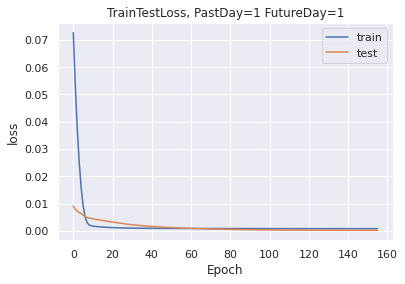

Train Score: 0.00079 MSE (0.03 RMSE)
Test Score: 0.00016 MSE (0.01 RMSE)


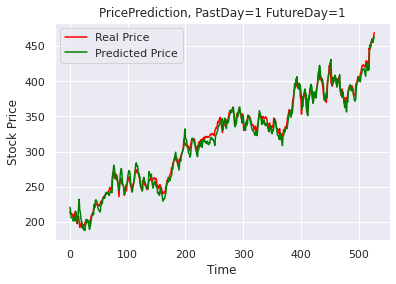

In [ ]:
# build model use previous day to predict next day
X_train, Y_train = Trainer(X, 1, 1)

# split training data and validation data
X_train, X_test, y_train, y_test = splitData(X_train, Y_train, 0.3)

# from 2 dimmension to 3 dimension
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]

model = OneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])
TrainTestLossPlotting(history, 1, 1)
model_score(model, X_train, y_train, X_test, y_test)
y_predict = model.predict(X_test)
y_pred = pd.DataFrame(y_predict[0:,0,0], columns = ['y_pred'])
ytest = pd.DataFrame(y_test[0:,0,0], columns = ['ytest'])
PricePredictionPlotting(denormalization(ytest),denormalization(y_pred), 1, 1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                1200      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 66ms/step - loss: 0.0815 - val_loss: 0.0367
Epoch 2/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0238 - val_loss: 0.0310
Epoch 3/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0158 - val_loss: 0.0227
Epoch 4/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0156
Epoch 5/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0076 - val_loss: 0.0120
Epoch 6/

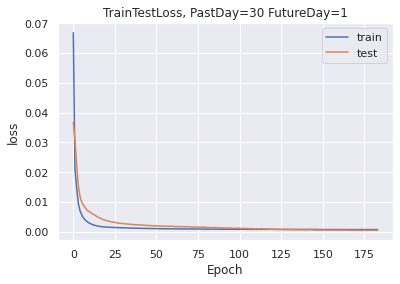

Train Score: 0.00078 MSE (0.03 RMSE)
Test Score: 0.00050 MSE (0.02 RMSE)


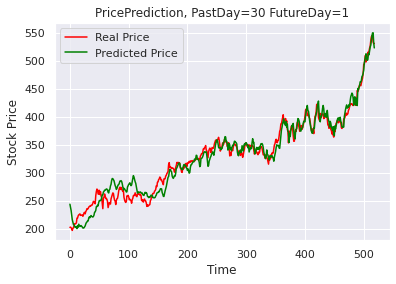

In [ ]:
# build Data, use previous 30 days to predict next day

X_train, Y_train = Trainer(X, 30, 1)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, X_test, y_train, y_test = splitData(X_train, Y_train, 0.3)
model = ManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])
TrainTestLossPlotting(history, 30, 1)
model_score(model, X_train, y_train, X_test, y_test)
y_predict = model.predict(X_test)
y_pred = pd.DataFrame(y_predict[0:,0], columns = ['y_pred'])
ytest = pd.DataFrame(y_test[0:,0], columns = ['ytest'])
PricePredictionPlotting(denormalization(ytest),denormalization(y_pred),30, 1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 1)              0         
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 2s 55ms/step - loss: 0.1823 - val_loss: 0.0151
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.1505 - val_loss: 0.0133
Epoch 3/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.1299 - val_loss: 0.0117
Epoch 4/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.1088

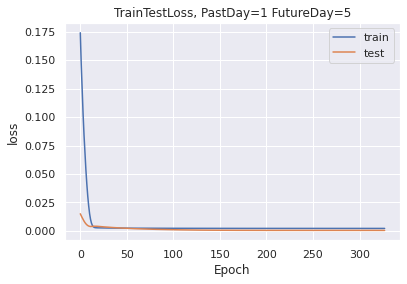

Train Score: 0.00221 MSE (0.05 RMSE)
Test Score: 0.00048 MSE (0.02 RMSE)


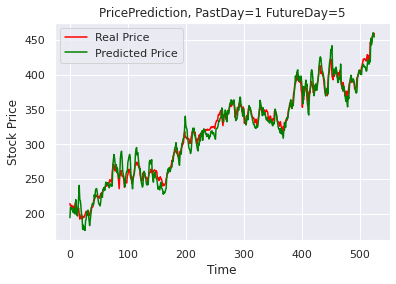

In [ ]:
# build Data, use previous day to predict next 5 days
X_train, Y_train = Trainer(X, 1, 5)
X_train, X_test, y_train, y_test = splitData(X_train, Y_train, 0.3)
# from 2 dimmension to 3 dimension
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]
model = OneToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])
TrainTestLossPlotting(history, 1, 5)
model_score(model, X_train, y_train, X_test, y_test)
y_predict = model.predict(X_test)
y_pred = pd.DataFrame(y_predict[0:,0,0], columns = ['y_pred'])
ytest = pd.DataFrame(y_test[0:,0,0], columns = ['ytest'])
PricePredictionPlotting(denormalization(ytest),denormalization(y_pred), 1, 5)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 10)            1200      
_________________________________________________________________
dense_12 (Dense)             (None, 30, 1)             11        
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 78ms/step - loss: 0.0298 - val_loss: 0.0182
Epoch 2/1000
10/10 [==============================] - 0s 20ms/step - loss: 0.0205 - val_loss: 0.0121
Epoch 3/1000
10/10 [==============================] - 0s 23ms/step - loss: 0.0200 - val_loss: 0.0092
Epoch 4/1000
10/10 [==============================] - 0s 22ms/step - loss: 0.0154 - val_loss: 0.0079
Epoch 5/1000
10/10 [==============================] - 0s 22ms/step - loss: 0.0180 - val_loss: 0.0067
Epoch 6/

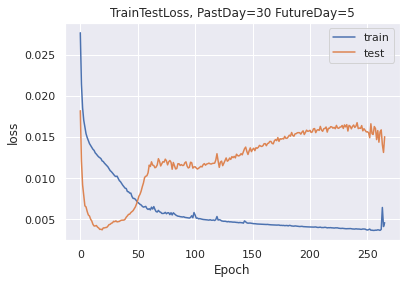

Train Score: 0.00428 MSE (0.07 RMSE)
Test Score: 0.01504 MSE (0.12 RMSE)


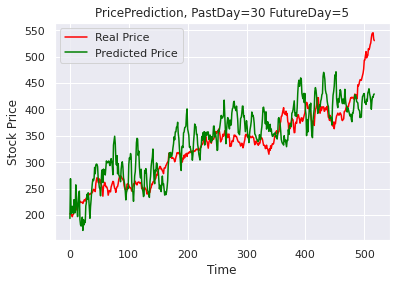

In [ ]:
# build model, use previous 30 daya to predict next 5 days

X_train, Y_train = Trainer(X, 30, 5)
X_train, X_test, y_train, y_test = splitData(X_train, Y_train, 0.3)
# from 2 dimmension to 3 dimension
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]
model = ManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])
TrainTestLossPlotting(history, 30, 5)
model_score(model, X_train, y_train, X_test, y_test)
y_predict = model.predict(X_test)
y_pred = pd.DataFrame(y_predict[0:,0,0], columns = ['y_pred'])
ytest = pd.DataFrame(y_test[0:,0,0], columns = ['ytest'])
PricePredictionPlotting(denormalization(ytest),denormalization(y_pred), 30, 5)